# LIGN167 Final Project

For our project, we are using a transformer to help make classifications on a given text. We are trying to classify, given a text, how a smoker or ex smoker is going about quitting their addictions.  
We webscraped data from https://www.quittrain.com/ and reddit to obtain the necessary datasets. 
We also followed a tutorial on how to use BERT to help make this project possible, the tutorial link is https://mccormickml.com/2019/07/22/BERT-fine-tuning/. 
0 - Healthy Substitutes 
1 - Cold Turkey 
2 - Nicotine Substitutes 

# Import Packages

In [31]:
import torch
from transformers import BertTokenizer, BertConfig
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import re
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from sklearn.metrics import matthews_corrcoef
import scikitplot as skplt


# Clean Data in Dataset

In [2]:
def clean_data(sentence):
    corpus = ""
    #this loads the data from sample_corpus.txt
    temp  = sentence.replace('\n','')
    temp = re.sub(r'[^a-zA-Z ,.,\']', ' ', temp)
    arrayOfWords = temp.split()
    corpus = ""
    for i in range(0,len(arrayOfWords)):
        if(arrayOfWords[i].count('.') >= 2):
            arrayOfWords[i] = arrayOfWords[i].replace('.', ' ')
    for i in range(0, len(arrayOfWords)):
        if(arrayOfWords[i].count(' ') > 1):
            count = arrayOfWords[i].count(' ')
            arrayOfWords[i] = arrayOfWords[i].replace(' ', '', count - 1)

    if(len(arrayOfWords) != 0):
        if(arrayOfWords[len(arrayOfWords)-1].find('.') == -1):
            arrayOfWords[len(arrayOfWords)-1] = arrayOfWords[len(arrayOfWords)-1]+"."

    for word in arrayOfWords:
        corpus = corpus + " " + word
    corpus = corpus.strip()	
    if(len(corpus.split()) < 5):
        return None
    elif(len(corpus.split()) > 400):
        return None
    return corpus

# Extract Training Data

In [3]:
def getTrainingData():
    # First DataSet
    df_cold_turkey = pd.read_csv("training_cold_turkey.csv", delimiter = ',', header = None, names = ['label', 'sentence'])
    df_vaping_ex = pd.read_csv("training_vape_ex.csv", delimiter = ',', header = None, names = ['label', 'sentence'])
    df_bad_vape = pd.read_csv("training_bad_vape.csv", delimiter = ',', header = None, names = ['label', 'sentence'])

    # Second DataSet
    df_cold_turkey = df_cold_turkey.dropna(subset=['sentence', 'label'])
    df_cold_turkey["sentence"] = df_cold_turkey["sentence"].apply(clean_data)
    df_cold_turkey = df_cold_turkey.dropna(subset=['sentence', 'label'])

    # Third DataSet
    df_vaping_ex = df_vaping_ex.dropna(subset=['sentence', 'label'])
    df_vaping_ex["sentence"] = df_vaping_ex["sentence"].apply(clean_data)
    df_vaping_ex = df_vaping_ex.dropna(subset=['sentence', 'label'])

    df_bad_vape = df_bad_vape.dropna(subset=['sentence', 'label'])
    df_bad_vape["sentence"] = df_bad_vape["sentence"].apply(clean_data)
    df_bad_vape = df_bad_vape.dropna(subset=['sentence', 'label'])

    # Concatenate all three dataset into one
    allSents = df_cold_turkey.sentence.values
    allSents = np.concatenate((allSents,df_bad_vape.sentence.values))
    allSents = np.concatenate((allSents,df_vaping_ex.sentence.values))
    
    # Extract labels (i.e classification)
    labels = pd.to_numeric(df_cold_turkey.label.values)
    labels = np.concatenate((labels,pd.to_numeric(df_bad_vape.label.values)))
    labels = np.concatenate((labels,pd.to_numeric(df_vaping_ex.label.values)))
    allSents = ["[CLS] " + sentence + " [SEP]" for sentence in allSents]
    
    return allSents, labels


In [4]:
output1, output2 = getTrainingData()
print("Length of dataset: ", len(output1))
print("Data Suitable for BERT: ")
print(output1)
print("-------------------------------------")
print("Labels: ")
print(output2)

Length of dataset:  9164
Data Suitable for BERT: 
['[CLS] The hardest thing is on a day that you re bored. You notice at the most. But if you re just sitting there playing video games or just sitting there doing work or homework, you start to feel it. [SEP]', '[CLS] The more you think about it the more your head starts to hurt. [SEP]', "[CLS] I used to get places minutes early so I could smoke one or two beforehand, sounds absolutely stupid but my timekeeping is absolutely terrible now, I'm constantly late for stuff. [SEP]", "[CLS] Other than that, quitting cold turkey was easy, I didn't wait to finish a pack I think I had about cigs left in the pack when I decided I was done, if I'd finished the pack first I would have made excuses to keep smoking. If that made sense. [SEP]", "[CLS] Not relapsing. Seems like the obvious answer but it's really hard not to relapse when your brain constantly tries to find excuses to smoke. [SEP]", '[CLS] I just realized that smoking pork was way more del

# Extract Testing Data

In [5]:
def getTestingData():
    test_cold_turkey = pd.read_csv("testing_cold_turkey.csv", delimiter = ',', header = None, names = ['label', 'sentence'])
    test_cold_turkey = test_cold_turkey.dropna(subset=['sentence', 'label'])
    test_cold_turkey["sentence"] = test_cold_turkey["sentence"].apply(clean_data)
    test_cold_turkey = test_cold_turkey.dropna(subset=['sentence', 'label'])

    test_vaping_ex = pd.read_csv("testing_vape_ex.csv", delimiter = ',', header = None, names = ['label', 'sentence'])
    test_vaping_ex = test_vaping_ex.dropna(subset=['sentence', 'label'])
    test_vaping_ex["sentence"] = test_vaping_ex["sentence"].apply(clean_data)
    test_vaping_ex = test_vaping_ex.dropna(subset=['sentence', 'label'])

    test_bad_vape = pd.read_csv("testing_bad_vape.csv", delimiter = ',', header = None, names = ['label', 'sentence'])
    test_bad_vape = test_bad_vape.dropna(subset=['sentence', 'label'])
    test_bad_vape["sentence"] = test_bad_vape["sentence"].apply(clean_data)
    test_bad_vape = test_bad_vape.dropna(subset=['sentence', 'label'])

    testing_allSents = test_cold_turkey.sentence.values
    testing_allSents = np.concatenate((testing_allSents,test_vaping_ex.sentence.values))
    testing_allSents = np.concatenate((testing_allSents,test_bad_vape.sentence.values))
    testing_labels = pd.to_numeric(test_cold_turkey.label.values)
    testing_labels = np.concatenate((testing_labels,pd.to_numeric(test_vaping_ex.label.values)))
    testing_labels = np.concatenate((testing_labels,pd.to_numeric(test_bad_vape.label.values)))

    testing_allSents = ["[CLS] " + sent + " [SEP]" for sent in testing_allSents]
    
    return testing_allSents, testing_labels

# Initialize Bert's Tokenizer

In [6]:
def createTokenizer():
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    return tokenizer 

In [7]:
def tokenizeData(token, allSents):
    tokenized_texts = [token.tokenize(sent) for sent in allSents]
    return tokenized_texts

In [8]:
token = createTokenizer()
print("Tokenized version of the first sentence")
tokenText = tokenizeData(token,output1)
print(tokenText[0])

I1209 21:29:25.409069 140540938377024 tokenization.py:190] loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/t1wan/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


Tokenized version of the first sentence
['[CLS]', 'the', 'hardest', 'thing', 'is', 'on', 'a', 'day', 'that', 'you', 're', 'bored', '.', 'you', 'notice', 'at', 'the', 'most', '.', 'but', 'if', 'you', 're', 'just', 'sitting', 'there', 'playing', 'video', 'games', 'or', 'just', 'sitting', 'there', 'doing', 'work', 'or', 'homework', ',', 'you', 'start', 'to', 'feel', 'it', '.', '[SEP]']


# Accuracy Function

In [13]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Time to Train and Validate

In [32]:
def train(model,device,optimizer,training_dataloader,testing_dataloader,validation_dataloader,prediction_dataloader):
    train_loss_set = []
    epochs = 1

    # BERT training loop
    for _ in trange(epochs, desc="Epoch"):  

        # Set the model to training mode
        model.train()  
        # Tracking variables
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0
        # Train the data for one epoch
        for step, batch in enumerate(training_dataloader):
            print("start of loop")
        # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            # Unpack the inputs from our dataloader
            b_input_ids, b_input_mask, b_labels = batch
            b_input_ids = b_input_ids.to(torch.int64)
            # Clear out the gradients (by default they accumulate)

            optimizer.zero_grad()

            # Forward pass
            loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

            train_loss_set.append(loss.item())    

            loss.backward()

            # Update parameters and take a step using the computed gradient

            optimizer.step()

            # Update tracking variables
            tr_loss += loss.item()
            nb_tr_examples += b_input_ids.size(0)
            nb_tr_steps += 1
        print("Train loss: {}".format(tr_loss/nb_tr_steps))    
    ## VALIDATION

    # Put model in evaluation mode
    model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
          # Forward pass, calculate logit predictions
          logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    
    #Plot training loss 
    plt.figure(figsize=(15,8))
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.plot(train_loss_set)
    plt.show()
    
    model.eval()
    # Tracking variables 
    predictions , true_labels = [], []
    # Predict 
    for batch in prediction_dataloader:
    # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up prediction
        with torch.no_grad():
    # Forward pass, calculate logit predictions
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()  
    # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

    # Import and evaluate each test batch using Matthew's correlation coefficient
    matthews_set = []
    for i in range(len(true_labels)):
        matthews = matthews_corrcoef(true_labels[i],
        np.argmax(predictions[i], axis=1).flatten())
    matthews_set.append(matthews)

    # Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
    flat_predictions = [item for sublist in predictions for item in sublist]
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
    flat_true_labels = [item for sublist in true_labels for item in sublist]
    
#     copy_pred = np.array(flat_predictions)
#     copy_true = np.array(flat_true_labels)
    
    print('Classification accuracy using BERT Fine Tuning: {0:0.2%}'.format(matthews_corrcoef(flat_true_labels, flat_predictions)))
    plotCRF(flat_true_labels, flat_predictions)

#     np.savetxt("predictions.csv", copy_pred, delimiter=",")
#     np.savetxt("truelabel.csv", copy_true, delimiter="," )

In [33]:
def plotCRF(flat_true_labels, flat_predictions):
    skplt.metrics.plot_confusion_matrix(flat_true_labels, flat_predictions, figsize=(12,15))


In [25]:
def main():
    trainingSet, trainingLabels = getTrainingData()
    testingSet, testingLabels = getTestingData()
    token = createTokenizer()
    tokenizedTrainingSet = tokenizeData(token,trainingSet)
    tokenizedTestingSet = tokenizeData(token,testingSet)
    
    # Define GPU usage
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)

    # Pad input tokens
    padded_input = pad_sequences([token.convert_tokens_to_ids(txt) for txt in tokenizedTrainingSet],
                              maxlen=512, dtype="long", truncating="post", padding="post")
    
    # Convert each tokens to their respective index number in BERT vocab
    padded_input = [token.convert_tokens_to_ids(x) for x in tokenizedTrainingSet]
    padded_input = pad_sequences(padded_input, maxlen=512, dtype="long", truncating="post", padding="post")
    
    attention_masks = []
    # Mask each token with 1's and pad it with zeros after
    for s in padded_input:
        updated_mask = [float(i>0) for i in s]
        attention_masks.append(updated_mask)
        
    # library used to split training data
    training_inputs, validation_inputs, training_labels, validation_labels = train_test_split(padded_input, 
                                                                                        trainingLabels
                                                                                        ,random_state=2018, 
                                                                                        test_size=0.1)
    training_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                           padded_input,
                                                           random_state=2018, 
                                                           test_size=0.1)

    # Convert all the training data into tensors
    training_inputs = torch.tensor(training_inputs)
    validation_inputs = torch.tensor(validation_inputs)
    training_labels = torch.tensor(training_labels)
    validation_labels = torch.tensor(validation_labels)
    training_masks = torch.tensor(training_masks)
    validation_masks = torch.tensor(validation_masks)

    batch_size = 3

    # Create an iterator training data
    training_data = TensorDataset(training_inputs, training_masks, training_labels)
    training_sampler = RandomSampler(training_data)
    training_dataloader = DataLoader(training_data, sampler=training_sampler, batch_size=batch_size)
    
    # Create an iterator for training validation data
    validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
    validation_sampler = SequentialSampler(validation_data)
    training_validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

    # Define Bert Model for classification
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
    model.cuda()

    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]

    optimizer = BertAdam(optimizer_grouped_parameters,lr=2e-5,warmup=.1)

    testing_ids = pad_sequences([token.convert_tokens_to_ids(x) for x in tokenizedTestingSet],
                              maxlen=512, dtype="long", truncating="post", padding="post")
    # Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
    testing_ids = [token.convert_tokens_to_ids(x) for x in tokenizedTestingSet]
    testing_ids = pad_sequences(testing_ids, maxlen=512, dtype="long", truncating="post", padding="post")
    # Create attention masks
    attention_masks = []
    # Create a mask of 1s for each token followed by 0s for padding
    for seq in testing_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask) 

    # create test tensors
    testing_inputs = torch.tensor(testing_ids)
    testing_masks = torch.tensor(attention_masks)
    testing_labels = torch.tensor(testingLabels)
    
    batch_size = 1
    
    testing_data = TensorDataset(testing_inputs, testing_masks, testing_labels)
    testing_sampler = SequentialSampler(testing_data)
    testing_dataloader = DataLoader(testing_data, sampler=testing_sampler, batch_size=batch_size)
    
    # Ready to Train
    train(model,device,optimizer,training_dataloader,testing_dataloader,training_validation_dataloader,testing_dataloader)

I1210 00:33:18.970741 140540938377024 tokenization.py:190] loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/t1wan/.pytorch_pretrained_bert/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
I1210 00:33:39.426517 140540938377024 modeling.py:580] loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased.tar.gz from cache at /home/t1wan/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba
I1210 00:33:39.431066 140540938377024 modeling.py:588] extracting archive file /home/t1wan/.pytorch_pretrained_bert/9c41111e2de84547a463fd39217199738d1e3deb72d4fec4399e6e241983c6f0.ae3cef932725ca7a30cdcb93fc6e09150a55e2a130ec7af63975a16c153ae2ba to temp dir /tmp/tmpatxdqv2e
I1210 00:33:43.285745 140540938377024 modeling.

start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start of loop
start 

Epoch: 100%|██████████| 1/1 [12:33<00:00, 753.10s/it]

Train loss: 0.6642362676974536


Validation Accuracy: 0.7516339869281036


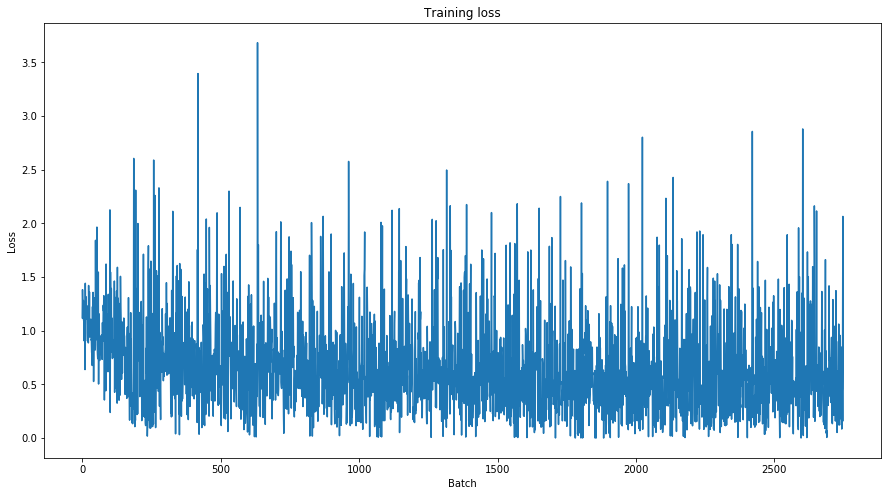

Classification accuracy using BERT Fine Tuning: 57.94%


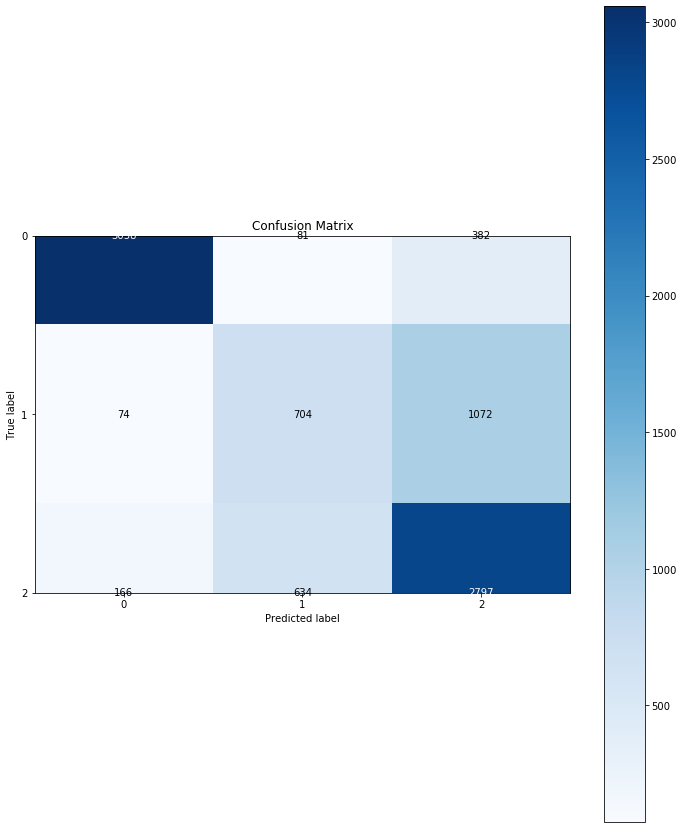

In [34]:
main()